In [121]:
import numpy as np
from numpy.ctypeslib import ndpointer 

import matplotlib.pyplot as plt
import numba as nb

from tqdm import trange, tqdm
from imageio import imread, imsave
from skimage.measure import label, regionprops
from skimage.color import rgb2hsv, hsv2rgb
from skimage.filters import threshold_otsu

import ctypes 
import os
from time import sleep

C:\Users\user\AppData\Local\Temp\ipykernel_11656\553579033.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imread('gen.png')


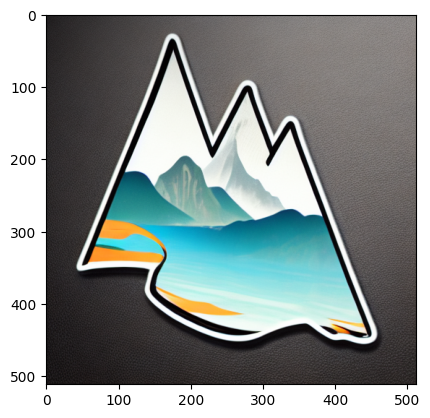

In [122]:
img = imread('gen.png')
plt.imshow(img)

In [123]:
r, vis, b = [img[:, :, i] for i in range(3)]

In [124]:
t = r < threshold_otsu(r)
lb = label(t)
big1 = lb == 1
big2 = lb == 0

s1 = big1[0].sum() + big1[-1].sum() + big1[:, 0].sum() + big1[:, -1].sum()
s2 = big2[0].sum() + big2[-1].sum() + big2[:, 0].sum() + big2[:, -1].sum()

if s1 > s2:
    msk = lb == 1
else:
    msk = lb == 0

newmsk = np.zeros((512, 512, 3))
newmsk[~msk, :] = 1
newmsk = newmsk.astype('bool')

img = rgb2hsv(img)

In [125]:
clrs = np.array([[h/50, 0.7, 0.7] for h in range(50)])
clrs = np.vstack((clrs, [[0., 0., 0.], [0., 0., 1.]]))

In [126]:
@nb.njit
def mark(img, itsa):
    nimg = np.zeros_like(img)
    for i in nb.prange(img.shape[0]):
        # for j in nb.prange(img.shape[1]):
        px = img[i]
        if (px == np.array([0, 0, 0], dtype='float64')).sum() != 3:
            nimg[i] = itsa[np.argmin(np.abs(px - itsa).sum(axis=1))]
    return nimg

In [127]:
clrmsk = mark(img[~msk], clrs)
nimg = np.zeros_like(img)
nimg[~msk] = clrmsk
# nimg = hsv2rgb(nimg)

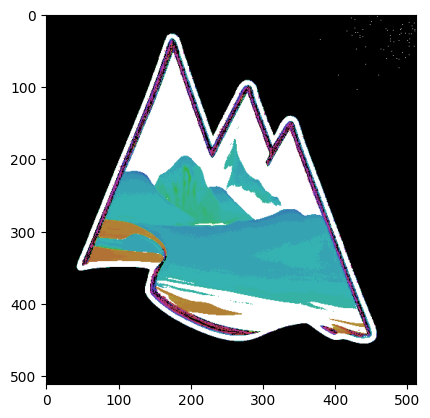

In [128]:
plt.imshow(hsv2rgb(nimg))

In [129]:
from time import sleep

In [154]:
nnimg = nimg.copy()
cnt, a = 0, 0
for color in tqdm(clrs):
    color = color.copy()
    f = (nnimg == color).sum(axis=2) == 3
    lbs = label(f, connectivity=1)
    regp = regionprops(lbs)
    for reg in regp:
        cnt += 1
        a += reg.area
        if reg.area < 15:
            for cord in reg.coords:
                x, y = cord
                nnimg[x, y] = -1
print(a / cnt)

100%|██████████| 52/52 [00:01<00:00, 47.75it/s] 

27.06142252503355


In [131]:
def check(x, y, shape):
    if x >= 0 and y >= 0 and x < shape[0] and y < shape[1]:
        return True
    return False

In [138]:
n = 1
var = [[i, j] for i in range(-n, n + 1) for j in range(-n, n + 1) if not(i == 0 and j == 0)]

In [181]:
def bfs(x, y):
    global vis, nnimg, var, cnt
    vis1 = vis.copy()
    vis[x, y] = 1
    ln = [[x, y, 0, 0, [0, 0, 0]]]
    while len(ln) != 0:
        for x, y, flg, dist, clr in ln[:]:
            ln.pop(0)
            if dist < 10:
                for dx, dy in var:
                    xn, yn = x + dx, y + dy
                    if check(xn, yn, nnimg.shape):
                        if flg: 
                            nnimg[xn, yn] = clr
                            cnt += 1
                            if cnt % 1000 == 0:
                                plt.imshow(hsv2rgb(nnimg))
                                plt.show()
                            if not vis1[xn, yn]:
                                ln.append([xn, yn, flg, dist + 1, clr])
                                vis1[xn, yn] = 1
                        elif (nnimg[xn, yn] == (0, 0, 0)).sum() != 3:
                            clr = nnimg[xn, yn]
                            flg = 1
                            ln.append([x, y, flg, 0, clr])
                            vis1[x, y] = 1
                        elif not vis[xn, yn]:
                            vis[xn, yn] = 1
                            ln.append([xn, yn, flg, dist + 1, clr])

In [182]:
nnimg = nimg.copy()

In [183]:
vis = nnimg != -1
vis = vis[:, :, 0]

In [ ]:
cnt = 0
for i in trange(nnimg.shape[0]):
    for j in range(nnimg.shape[1]):
        if not vis[i, j]:
            bfs(i, j)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


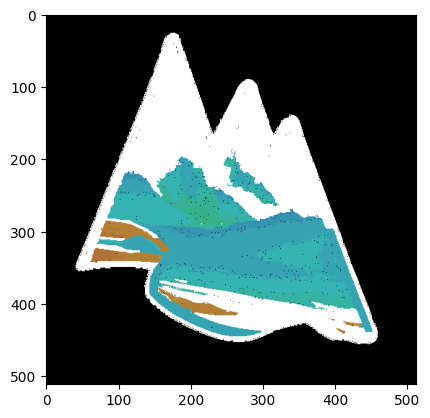

In [162]:
plt.imshow(hsv2rgb(nnimg))

In [ ]:
path = 'D:\\Python_progs\\AI\\Artist\\tests\\test_cython\\'

os.system(f'gcc -Wall -pedantic -shared -fPIC -o {path}lib.dll {path}test.c')

doublepp = ndpointer(dtype=np.uintp, ndim=1, flags='C') 

dll = ctypes.CDLL(path + 'lib.dll', winmode=0) 

foobar = dll.foobar 
foobar.argtypes = [ctypes.c_int, ctypes.c_int, doublepp] 
foobar.restype = None 

def get_args(x: np.ndarray): 
    xpp = (x.__array_interface__['data'][0] + np.arange(x.shape[0]) * x.strides[0]).astype(np.uintp) 
    m = ctypes.c_int(x.shape[0]) 
    n = ctypes.c_int(x.shape[1]) 
    return m, n, xpp

x = np.zeros([2, 2], dtype=np.double)
foobar(*get_args(x))